In [1]:
import nibabel as nib
import numpy
import dipy
import numpy as np
import vtk
from nibabel.affines import apply_affine
import matplotlib.pyplot as plt
from vtk.util import numpy_support as ns
from six import iteritems
from dipy.tracking.streamline import values_from_volume

In [2]:
l5_path  = '/media/imag2/USBKEYTWO/1-4-29/1-4-29_170227_L5.vtk'
s1_path  = '/media/imag2/USBKEYTWO/1-4-29/1-4-29_170227_S1.vtk'
s2_path  = '/media/imag2/USBKEYTWO/1-4-29/1-4-29_170227_S2.vtk'
s3_path  = '/media/imag2/USBKEYTWO/1-4-29/1-4-29_170227_S3.vtk'

FA_path = '/media/imag2/USBKEYTWO/1-4-29/1-4-29_170227_VolumeFA.nii'

In [3]:
def load_nii(fname):
    img = nib.load(fname)
    return img.get_fdata(), img.affine

def read_vtk(filename):
    if filename.endswith('xml') or filename.endswith('vtp'):
        polydata_reader = vtk.vtkXMLPolyDataReader()
    else:
        polydata_reader = vtk.vtkPolyDataReader()

    polydata_reader.SetFileName(filename)
    polydata_reader.Update()

    polydata = polydata_reader.GetOutput()

    return vtkpolydata_to_tracts(polydata)


def vtkpolydata_to_tracts(polydata):
    result = {'lines': ns.vtk_to_numpy(polydata.GetLines().GetData()),
              'points': ns.vtk_to_numpy(polydata.GetPoints().GetData()), 'numberOfLines': polydata.GetNumberOfLines()}

    data = {}
    if polydata.GetPointData().GetScalars():
        data['ActiveScalars'] = polydata.GetPointData().GetScalars().GetName()
    if polydata.GetPointData().GetVectors():
        data['ActiveVectors'] = polydata.GetPointData().GetVectors().GetName()
    if polydata.GetPointData().GetTensors():
        data['ActiveTensors'] = polydata.GetPointData().GetTensors().GetName()

    for i in range(polydata.GetPointData().GetNumberOfArrays()):
        array = polydata.GetPointData().GetArray(i)
        np_array = ns.vtk_to_numpy(array)
        if np_array.ndim == 1:
            np_array = np_array.reshape(len(np_array), 1)
        data[polydata.GetPointData().GetArrayName(i)] = np_array

    result['pointData'] = data

    tracts, data = vtkpolydata_dictionary_to_tracts_and_data(result)
    return tracts, data


def vtkpolydata_dictionary_to_tracts_and_data(dictionary):
    dictionary_keys = {'lines', 'points', 'numberOfLines'}
    if not dictionary_keys.issubset(dictionary):
        raise ValueError("Dictionary must have the keys lines and points" + repr(dictionary))

    tract_data = {}
    tracts = []

    lines = np.asarray(dictionary['lines']).squeeze()
    points = dictionary['points']

    actual_line_index = 0
    number_of_tracts = dictionary['numberOfLines']
    original_lines = []
    for _ in range(number_of_tracts):
        tracts.append(points[lines[actual_line_index + 1:actual_line_index + lines[actual_line_index] + 1]])
        original_lines.append(
            np.array(lines[actual_line_index + 1:actual_line_index + lines[actual_line_index] + 1], copy=True))
        actual_line_index += lines[actual_line_index] + 1

    if 'pointData' in dictionary:
        point_data_keys = [it[0] for it in iteritems(dictionary['pointData']) if isinstance(it[1], np.ndarray)]

        for k in point_data_keys:
            array_data = dictionary['pointData'][k]
            if k not in tract_data:
                tract_data[k] = [array_data[f] for f in original_lines]
            else:
                np.vstack(tract_data[k])
                tract_data[k].extend([array_data[f] for f in original_lines[-number_of_tracts:]])

    return tracts, tract_data

In [4]:
FA, affine = load_nii(FA_path)
l5 = read_vtk(l5_path)[0]
s1 = read_vtk(s1_path)[0]
s2 = read_vtk(s2_path)[0]
s3 = read_vtk(s3_path)[0]

FA = (FA - np.amin(FA)) / (np.amax(FA) - np.amin(FA))

In [5]:
def get_hist(bundle):
    def streamlines_mapvolume(streamlines, volume, affine):
        #inverse = np.linalg.inv(affine)
        #streamlines = [apply_affine(inverse, np.array(s)) for s in streamlines]
        mapping = values_from_volume(volume, streamlines, affine)
        return mapping

    scalar_measurement = streamlines_mapvolume(bundle, FA, affine)
    scalar_measurement = [item for sublist in scalar_measurement for item in sublist]
    return np.asarray(scalar_measurement)


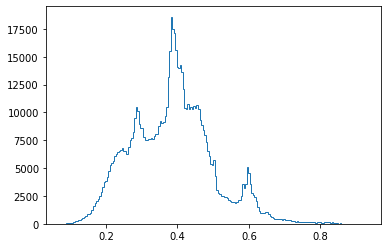

In [6]:
_ = plt.hist(get_hist(l5), histtype = 'step', bins=200)
plt.show()

In [ ]:
_ = plt.hist(get_hist(s1), histtype = 'step', bins=200)
plt.show()

In [ ]:
plt.hist(get_hist(s2), histtype = 'step', bins=200)
plt.show()

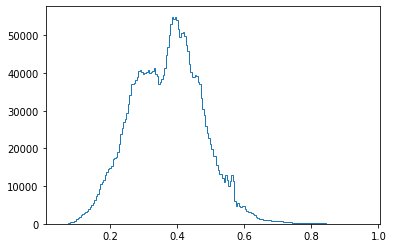

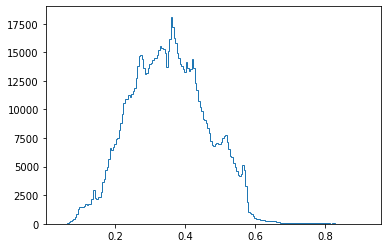

In [8]:
plt.hist(get_hist(s2), histtype = 'step', bins=200)
plt.show()